In [1]:
import qutip as qt 
from qutip.qip.operations import ry, rx
import numpy as np
import matplotlib.pyplot as plt
import imageio
from tqdm import tqdm
import os

In [6]:
def plot_wigner(
    psi,
    xvec=np.linspace(-5, 5, 101),
    ax=None,
    grid=True,
    yvec=None,
    vmin=-2 / np.pi,
    vmax=+2 / np.pi,
):
    yvec = xvec if yvec is None else yvec
    dx = xvec[1] - xvec[0]
    dy = yvec[1] - yvec[0]
    extent = (
        xvec[0] - dx / 2.0,
        xvec[-1] + dx / 2.0,
        yvec[0] - dy / 2.0,
        yvec[-1] + dy / 2.0,
    )
    W = qt.wigner(psi, xvec,yvec, g=2) 
    
    if ax is None:
        fig = plt.figure()
        ax = plt.gca()
    ax.imshow(
        W,
        origin="lower",
        cmap="seismic",
        vmin=vmin,
        vmax=vmax,
        extent = extent,
        interpolation=None,
    )
    # plt.colorbar()
    if grid:
        ax.grid()
    return fig, ax

def create_gif(states, gif_name, fps = 20, tensored = True):

    if tensored:
        states = [qt.ptrace(state, 1) for state in states]
    # Generate and save frames
    filenames = []
    for i, state in enumerate(states):
        fig, ax = plot_wigner(state)
        filename = f'frame_{i}.png'
        fig.savefig(filename)
        filenames.append(filename)
        plt.close(fig)

    # Create GIF
    with imageio.get_writer(gif_name, mode='I', duration =0.05, fps = fps ) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

    # Remove frame files
    for filename in filenames:
        os.remove(filename)


# Define System Parameters
N = 100

# Operators
# Cavity Operators
a = qt.destroy(N)
at = qt.create(N)
Ic = qt.qeye(N)

# Qubit Operators
sx = qt.sigmax()
sy = qt.sigmay()
sz = qt.sigmaz()
Iq = qt.qeye(2)

# States
g = qt.basis(2, 0)
e = qt.basis(2, 1)
vac = qt.basis(N, 0)

# Gates
def Ry(theta):
    return qt.tensor(ry(theta), Ic)

def Rx(theta):
    return qt.tensor(rx(theta), Ic)

# Hamiltonians
def H_dispersive(chi_ge, chi_ef):
    return qt.tensor((-chi_ge * g.proj() + chi_ef * e.proj()), a.dag() * a)

def H_drive(epsilon):
    """ Drive Hamiltonian. Final displacement is epsilon*t """
    return np.conjugate(1j * epsilon) * a + a.dag() * 1j * epsilon

def H_rotation(omega, theta):
    """
    Rotation Hamiltonian.
    omega: Rotation angle
    theta: Rotation axis, 0 -> Y, pi/2 -> X
    Final rotation angle is omega*t
    """
    return omega / 2 * (np.cos(theta) * sy + np.sin(theta) * sx)

# Time Evolution
def time_evolution(H, psi, tlist):
    return qt.sesolve(H, psi, tlist)

# ECD Sequence
def ecd_sequence(psi0, epsilon, chi_ge, chi_ef, t_rotation, t_displace, t_wait):
    """
    Execute the ECD sequence.
    """
    # 1. First positive displacement
    epsilon1 = 4 / t_displace[-1]
    psis1 = time_evolution(qt.tensor(Iq, H_drive(epsilon1)) , psi0, t_displace).states
    
    # 2. First Wait time
    psis2 = time_evolution(H_dispersive(chi_ge, chi_ef), psis1[-1], t_wait).states
    print(epsilon * np.cos(chi_ge * t_wait[-1]))
    # 3. First negative displacement
    epsilon23 = -epsilon * np.cos(chi_ge * t_wait[-1]) / t_displace[-1]
    psis3 = time_evolution(qt.tensor(Iq, H_drive(epsilon23)) , psis2[-1], t_displace).states
    
    # 4. pi Rotation
    psis4 = time_evolution(qt.tensor(H_rotation(np.pi / t_rotation[-1], 0), Ic) , psis3[-1], t_rotation).states
    
    # 5. Second negative displacement
    psis5 = time_evolution(qt.tensor(Iq, H_drive(epsilon23)) , psis4[-1], t_displace).states
    
    # 6. Second Wait time
    psis6 = time_evolution(H_dispersive(chi_ge, chi_ef), psis5[-1], t_wait).states
    
    # 7. Second positive displacement
    epsilon4 = epsilon* np.cos(chi_ge * t_wait[-1]*2)/t_displace[-1]
    psis7 = time_evolution(qt.tensor(Iq, H_drive(epsilon4)) , psis6[-1], t_displace).states

    return psis1 + psis2 + psis3 + psis4 + psis5 + psis6 + psis7


def ecd_and_reverse_ecd(psi0, epsilon, chi_ge, chi_ef, t_rotation, t_displace, t_wait):
    # First ECD
    # 1. First positive displacement
    epsilon1 = 4 / t_displace[-1]
    psis1 = time_evolution(qt.tensor(Iq, H_drive(epsilon1)) + H_dispersive(chi_ge,chi_ef), psi0, t_displace).states
    # 2. First Wait time
    psis2 = time_evolution(H_dispersive(chi_ge,chi_ef), psis1[-1], t_wait).states
    # 3. First negative displacement
    epsilon23 = -epsilon * np.cos(chi_ge * t_wait[-1]) / t_displace[-1]
    psis3 = time_evolution(qt.tensor(Iq, H_drive(epsilon23))+ H_dispersive(chi_ge,chi_ef) , psis2[-1], t_displace).states
    # 4. pi Rotation
    psis4 = time_evolution(qt.tensor(H_rotation(np.pi*1/t_rotation[-1], 0),Ic) + H_dispersive(chi_ge,chi_ef), psis3[-1], t_rotation).states
    # 5. Second negative displacement
    psis5 = time_evolution(qt.tensor(Iq, H_drive(epsilon23)) + H_dispersive(chi_ge,chi_ef), psis4[-1], t_displace).states
    # 6. Second Wait time
    psis6 = time_evolution(H_dispersive(chi_ge,chi_ef), psis5[-1], t_wait).states
    # 7. Second positive displacement
    epsilon4 = epsilon* np.cos(chi_ge * t_wait[-1]*2)/t_displace[-1]
    psis7 = time_evolution(qt.tensor(Iq, H_drive(epsilon4)) + H_dispersive(chi_ge,chi_ef), psis6[-1], t_displace).states
    # Flip the qubit
    psis8 = Ry(np.pi)*psis7[-1]
    
    # Second ECD
    # 1. First positive displacement
    psis9 = time_evolution(qt.tensor(Iq, H_drive(-epsilon4)) + H_dispersive(chi_ge,chi_ef), psis8, t_displace).states
    # 2. First Wait time
    psis10 = time_evolution(H_dispersive(chi_ge,chi_ef), psis9[-1], t_wait).states
    # 3. First negative displacement
    psis11 = time_evolution(qt.tensor(Iq, H_drive(-epsilon23))+ H_dispersive(chi_ge,chi_ef) , psis10[-1], t_displace).states   
    # 4. pi Rotation
    psis12 = time_evolution(qt.tensor(H_rotation(np.pi*1/t_rotation[-1], 0),Ic) + H_dispersive(chi_ge,chi_ef), psis11[-1], t_rotation).states
    # 5. Second negative displacement
    psis13 = time_evolution(qt.tensor(Iq, H_drive(-epsilon23)) + H_dispersive(chi_ge,chi_ef), psis12[-1], t_displace).states
    # 6. Second Wait time
    psis14 = time_evolution(H_dispersive(chi_ge,chi_ef), psis13[-1], t_wait).states
    # 7. Second positive displacement
    psis15 = time_evolution(qt.tensor(Iq, H_drive(-epsilon1)) + H_dispersive(chi_ge,chi_ef), psis14[-1], t_displace).states
    
    return psis1 + psis2 + psis3 + psis4 + psis5 + psis6 + psis7 + [psis8] + psis9 + psis10 + psis11 + psis12 + psis13 + psis14 + psis15



In [8]:
# a dictionary that holds all the parameters for ecd_sequence
ecd_params = {
    'epsilon': 4,
    'chi_ge': 0.12*2*np.pi,
    'chi_ef': 0.12*2*np.pi,
    't_rotation': np.linspace(0, 0.06, 15),
    't_displace': np.linspace(0, 0.06, 15),
    't_wait': np.linspace(0, 0.25, 15)
}

# run the ecd sequence
psi0 = Ry(np.pi/2)*qt.tensor(g, vac)
psi1 = ecd_and_reverse_ecd(psi0, **ecd_params)


(<Figure size 640x480 with 1 Axes>, <Axes: >)

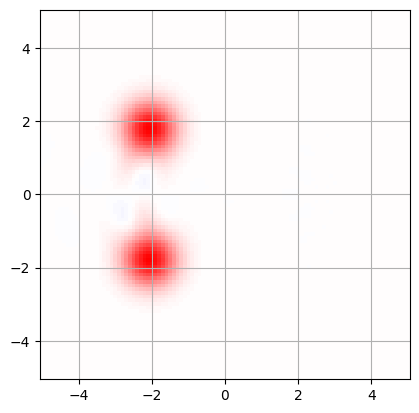

In [9]:
plot_wigner(qt.ptrace(psi1[114],1))

In [251]:
create_gif(psi1, 'ecd_reverse.gif', fps = 10)

C:\Users\jonat\AppData\Local\Temp\ipykernel_20292\3584358837.py:54: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


100%|██████████| 20/20 [00:01<00:00, 11.31it/s]


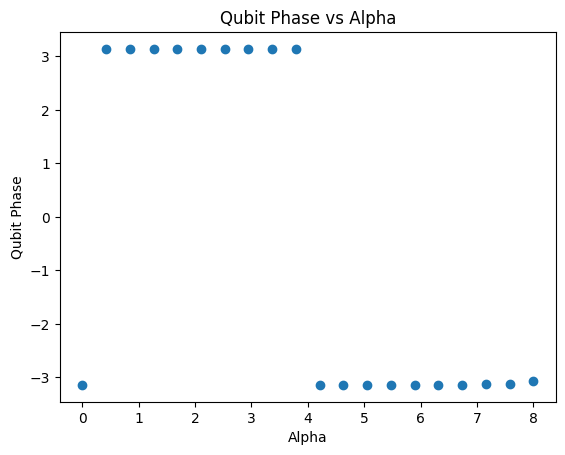

In [10]:
def sweep_alpha_measure_qubit_phase(alpha_list, ecd_params):
    """Sweeps the alpha list and measures the qubit phase"""
    phase_list = []
    for alpha in tqdm(alpha_list):
        psi0 = Ry(np.pi/2)*qt.tensor(g, vac)
        ecd_params['epsilon'] = alpha
        psi1 = ecd_and_reverse_ecd(psi0, **ecd_params)

        phase_list.append(np.angle(qt.ptrace(psi1[-1], 0)[0,1]))

    # Plot and save the results
    plt.plot(alpha_list, phase_list, 'o')
    plt.xlabel('Alpha')
    plt.ylabel('Qubit Phase')
    plt.title('Qubit Phase vs Alpha')
    
    # Create the phase_data folder if it doesn't exist
    if not os.path.exists('phase_data'):
        os.makedirs('phase_data')
    
    # Save the figure in the phase_data folder with the parameter name
    # Format parameters with less precision if detailed precision is not crucial
    epsilon_str = f"{float(ecd_params['epsilon']):.2f}"
    chi_ge_str = f"{float(ecd_params['chi_ge']/(2*np.pi)):.2f}"
    chi_ef_str = f"{float(ecd_params['chi_ef']/(2*np.pi)):.2f}"
    t_wait_str = f"{float(ecd_params['t_wait'][-1]):.2f}"

    # Construct a simpler filename
    filename = (
        f"phase_data/ECD_N{N}_"
        f"eps{epsilon_str}_"
        f"ge{chi_ge_str}_"
        f"ef{chi_ef_str}_"
        f"wait{t_wait_str}.png"
    )
    plt.savefig(filename)
    plt.show()

    return phase_list

alpha_list = np.linspace(0, 8, 20)
phase_list = sweep_alpha_measure_qubit_phase(alpha_list, ecd_params)


100%|██████████| 20/20 [00:01<00:00, 12.83it/s]


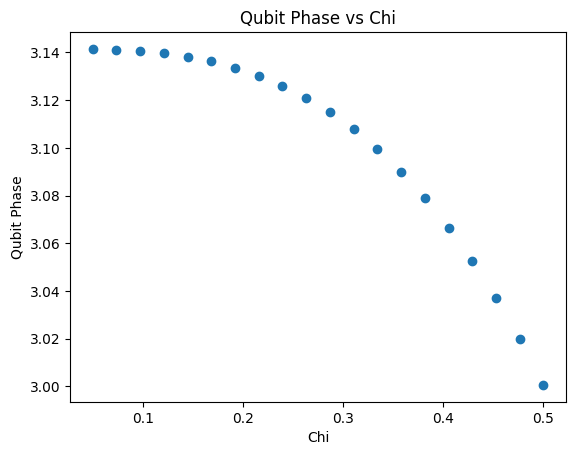

In [38]:
def sweep_chi_measure_qubit_phase(chi_list, ecd_params):
    """Sweeps the chi list and measures the qubit phase"""
    phase_list = []
    for chi in tqdm(chi_list):
        psi0 = Ry(np.pi/2)*qt.tensor(g, vac)
        ecd_params['chi_ge'] = chi
        ecd_params['chi_ef'] = chi
        psi1 = ecd_sequence(psi0, **ecd_params)

        phase_list.append(np.angle(qt.ptrace(psi1[-1], 0)[0,1]))

    # Plot and save the results
    plt.plot(chi_list, phase_list, 'o')
    plt.xlabel('Chi')
    plt.ylabel('Qubit Phase')
    plt.title('Qubit Phase vs Chi')
    
    # Create the phase_data folder if it doesn't exist
    if not os.path.exists('phase_data'):
        os.makedirs('phase_data')
    
    # Save the figure in the phase_data folder with the parameter name
    # Format parameters with less precision if detailed precision is not crucial
    epsilon_str = f"{float(ecd_params['epsilon']):.2f}"
    chi_ge_str = f"{float(ecd_params['chi_ge']/(2*np.pi)):.2f}"
    chi_ef_str = f"{float(ecd_params['chi_ef']/(2*np.pi)):.2f}"
    t_wait_str = f"{float(ecd_params['t_wait'][-1]):.2f}"

    # Construct a simpler filename
    filename = (
        f"phase_data/ECD_N{N}_"
        f"eps{epsilon_str}_"
        f"ge{chi_ge_str}_"
        f"ef{chi_ef_str}_"
        f"wait{t_wait_str}.png"
    )
    plt.savefig(filename)
    plt.show()

    return phase_list

chi_list = np.linspace(0.05, 0.5, 20)
phase_list = sweep_chi_measure_qubit_phase(chi_list, ecd_params)


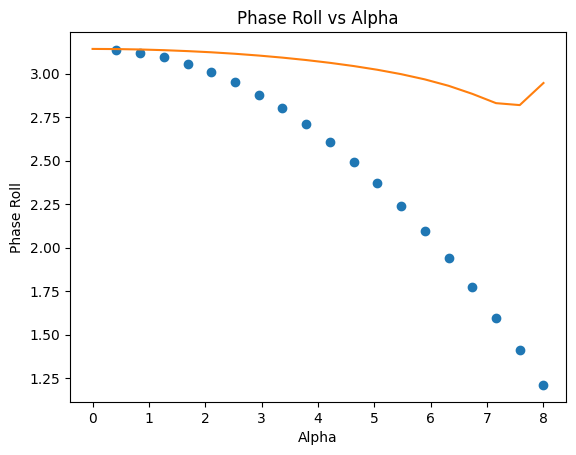

In [130]:
def phase_roll(alpha, chi, tau):
    return 2*alpha**2*np.sin(2*chi*tau)


# Define the parameters
chi = ecd_params['chi_ge']
tau = ecd_params['t_displace'][-1]

# Sweep and calculate the phase_roll values
phase_roll_list = [np.angle(np.exp(-1j*np.pi)*np.exp(-1j*phase_roll(alpha, chi, tau))) for alpha in alpha_list]

# Plot the results
plt.plot(alpha_list[1:], phase_roll_list[1:], 'o')
plt.plot(alpha_list, phase_list)
plt.xlabel('Alpha')
plt.ylabel('Phase Roll')
plt.title('Phase Roll vs Alpha')
plt.show()



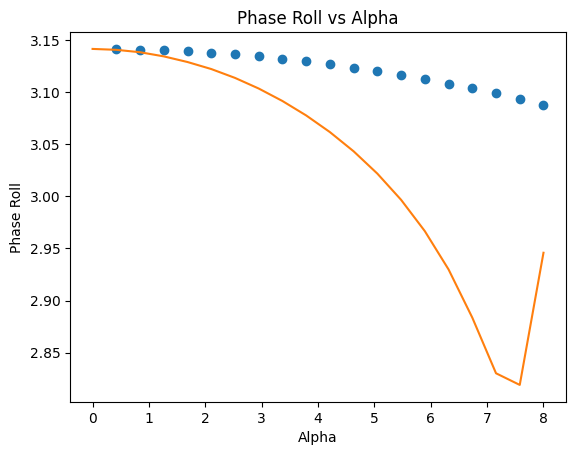

In [84]:
def phase_roll_amon(alpha, chi, tau):
    return 2*alpha**2*np.sin(chi*tau*2)**2*np.tan(chi*tau)


# Define the parameters

chi = ecd_params['chi_ge']
tau = ecd_params['t_displace'][-1]

# Sweep and calculate the phase_roll values
phase_roll_list_amon = [np.angle(np.exp(-1j*np.pi)*np.exp(-1j*phase_roll_amon(alpha, chi, tau))) for alpha in alpha_list]

# Plot the results
plt.plot(alpha_list[1:], phase_roll_list_amon[1:], 'o')
plt.plot(alpha_list, phase_list)
plt.xlabel('Alpha')
plt.ylabel('Phase Roll')
plt.title('Phase Roll vs Alpha')
plt.show()



### Phase, step by step

In [363]:
def ecd_and_reverse_ecd_step_by_step(psi0, epsilon, chi_ge, chi_ef, t_rotation, t_displace, t_wait):
    # First ECD
    # 1. First positive displacement
    psis1 = time_evolution(qt.tensor(Iq, H_drive(epsilon/t_displace[-1])) + H_dispersive(chi_ge,chi_ef), psi0, t_displace).states
    # 2. First Wait time
    # psis2 = time_evolution(H_dispersive(chi_ge,chi_ef), psis1[-1], t_wait).states
    # # 3. First negative displacement
    # psis3 = time_evolution(qt.tensor(Iq, H_drive(-epsilon*np.cos(chi_ge*t_displace[-1]/2)/t_displace[-1]))+ H_dispersive(chi_ge,chi_ef) , psis2[-1], t_displace).states
    # # 4. pi Rotation
    # psis4 = time_evolution(qt.tensor(H_rotation(np.pi*1/t_rotation[-1], 0),Ic) + H_dispersive(chi_ge,chi_ef), psis3[-1], t_rotation).states
    # # 5. Second negative displacement
    # psis5 = time_evolution(qt.tensor(Iq, H_drive(-epsilon*np.cos(chi_ge*t_displace[-1]/2)/t_displace[-1])) + H_dispersive(chi_ge,chi_ef), psis4[-1], t_displace).states
    # # 6. Second Wait time
    # psis6 = time_evolution(H_dispersive(chi_ge,chi_ef), psis5[-1], t_wait).states
    # # 7. Second positive displacement
    # psis7 = time_evolution(qt.tensor(Iq, H_drive(epsilon*np.cos(chi_ge*t_displace[-1])/t_displace[-1])) + H_dispersive(chi_ge,chi_ef), psis6[-1], t_displace).states
    # # Flip the qubit
    psis8 = Ry(np.pi)*psis1[-1]
    
    epsilon = -epsilon
    # Second ECD
    # 1. First positive displacement
    psis9 = time_evolution(qt.tensor(Iq, H_drive(epsilon/t_displace[-1])) + H_dispersive(chi_ge,chi_ef), psis8, t_displace).states
    # 2. First Wait time
    # psis10 = time_evolution(H_dispersive(chi_ge,chi_ef), psis9[-1], t_wait).states
    # # 3. First negative displacement
    # psis11 = time_evolution(qt.tensor(Iq, H_drive(-epsilon*np.cos(chi_ge*t_displace[-1]/2)/t_displace[-1]))+ H_dispersive(chi_ge,chi_ef) , psis10[-1], t_displace).states   
    # # 4. pi Rotation
    # psis12 = time_evolution(qt.tensor(H_rotation(np.pi*1/t_rotation[-1], 0),Ic) + H_dispersive(chi_ge,chi_ef), psis11[-1], t_rotation).states
    # # 5. Second negative displacement
    # psis13 = time_evolution(qt.tensor(Iq, H_drive(-epsilon*np.cos(chi_ge*t_displace[-1]/2)/t_displace[-1])) + H_dispersive(chi_ge,chi_ef), psis12[-1], t_displace).states
    # # 6. Second Wait time
    # psis14 = time_evolution(H_dispersive(chi_ge,chi_ef), psis13[-1], t_wait).states
    # # 7. Second positive displacement
    # psis15 = time_evolution(qt.tensor(Iq, H_drive(epsilon*np.cos(chi_ge*t_displace[-1])/t_displace[-1])) + H_dispersive(chi_ge,chi_ef), psis14[-1], t_displace).states
    
    return psis9

In [ ]:
# a dictionary that holds all the parameters for ecd_sequence
ecd_params = {
    'epsilon': 2,
    'chi_ge': 0.1*2*np.pi,
    'chi_ef': 0.1*2*np.pi,
    't_rotation': np.linspace(0, 0.01, 1000),
    't_displace': np.linspace(0, 0.01, 1000),
    't_wait': np.linspace(0, 0.5, 1000)
}

# run the ecd sequence
psi0 = Ry(np.pi/2)*qt.tensor(g, vac)
psi1 = ecd_sequence(psi0, **ecd_params)


In [ ]:
def sweep_alpha_measure_qubit_phase(alpha_list, ecd_params):
    """Sweeps the alpha list and measures the qubit phase"""
    phase_list = []
    for alpha in tqdm(alpha_list):
        psi0 = Ry(np.pi/2)*qt.tensor(g, vac)
        ecd_params['epsilon'] = alpha
        psi1 = ecd_sequence(psi0, **ecd_params)

        phase_list.append(np.angle(qt.ptrace(psi1[-1], 0)[0,1]))

    # Plot and save the results
    plt.plot(alpha_list, phase_list, 'o')
    plt.xlabel('Alpha')
    plt.ylabel('Qubit Phase')
    plt.title('Qubit Phase vs Alpha')
    
    # Create the phase_data folder if it doesn't exist
    if not os.path.exists('phase_data'):
        os.makedirs('phase_data')
    
    # Save the figure in the phase_data folder with the parameter name
    # Format parameters with less precision if detailed precision is not crucial
    epsilon_str = f"{float(ecd_params['epsilon']):.2f}"
    chi_ge_str = f"{float(ecd_params['chi_ge']/(2*np.pi)):.2f}"
    chi_ef_str = f"{float(ecd_params['chi_ef']/(2*np.pi)):.2f}"
    t_wait_str = f"{float(ecd_params['t_wait'][-1]):.2f}"

    # Construct a simpler filename
    filename = (
        f"phase_data/ECD_N{N}_"
        f"eps{epsilon_str}_"
        f"ge{chi_ge_str}_"
        f"ef{chi_ef_str}_"
        f"wait{t_wait_str}.png"
    )
    plt.show()

    return phase_list

alpha_list = np.linspace(0, 3, 20)
phase_list = sweep_alpha_measure_qubit_phase(alpha_list, ecd_params)
